# Phase 3: Uncertainty Quantification

**Objective:** Implement and validate uncertainty quantification methods

**Goals:**
- Implement Bootstrap Ensemble for uncertainty estimation
- Validate uncertainty quality (correlation with errors)
- Compare with baseline model
- Analyze calibration
- Prepare for escalation system

## 1. Setup and Imports

In [ ]:
print("=*60)",
PHASE 3 COMPLETE: UNCERTAINTY QUANTIFICATION")
print("=*60)",
,
\nAchievements:")
print("   - Bootstrap Ensemble with 30 models trained")
print("   - Uncertainty estimates generated for all predictions")
print("   - Uncertainty quality validated (correlation with errors)")
print("   - Calibration analyzed and compared")
print("   - Prediction intervals calculated")

print("\nKey Metrics (Validation Set):")
print(f"   Ensemble Accuracy: {accuracy_score(y_val, y_val_pred_ens):.4f}")
print(f"   Ensemble AUC-ROC:  {roc_auc_score(y_val, proba_val[:, 1]):.4f}")
print(f"   Mean Uncertainty:  {np.mean(uncertainty_val):.4f}")

# Calculate correlation
errors = (y_val != y_val_pred_ens).astype(int)
correlation = np.corrcoef(uncertainty_val, errors)[0, 1]
print(f"   Uncertainty-Error Correlation: {correlation:.4f}")

# Calculate metrics
metrics = UncertaintyMetrics()
corr_results = metrics.uncertainty_vs_error_correlation(
    y_val.values, y_val_pred_ens, uncertainty_val
)
print(f"   Uncertainty Ratio (Incorrect/Correct): {corr_results['uncertainty_ratio']:.4f}")

print("\nPhase 3 Success Criteria:")
if correlation > 0.3:
    print(f"   Strong correlation (>0.3): {correlation:.4f}")
elif correlation > 0.15:
    print(f"   Moderate correlation (>0.15): {correlation:.4f}")
else:
    print(f"   Weak correlation: {correlation:.4f}")

if corr_results['uncertainty_ratio'] > 1.5:
    print(f"   Uncertainty ratio >1.5: {corr_results['uncertainty_ratio']:.4f}")
else:
    print(f"   Uncertainty ratio: {corr_results['uncertainty_ratio']:.4f}")

print("\nNext: Phase 4 - Human Escalation System")
print("   - Define escalation criteria based on uncertainty")
print("   - Optimize thresholds for cost-benefit")
print("   - Implement EscalationSystem class")
print("=*60)")
## 2. Load Data and Best Model

In [2]:
# Load data splits
print("Loading data splits...")
X_train = pd.read_csv('../data/splits/X_train.csv')
X_val = pd.read_csv('../data/splits/X_val.csv')
X_test = pd.read_csv('../data/splits/X_test.csv')
y_train = pd.read_csv('../data/splits/y_train.csv').squeeze()
y_val = pd.read_csv('../data/splits/y_val.csv').squeeze()
y_test = pd.read_csv('../data/splits/y_test.csv').squeeze()

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Loading data splits...
Train shape: (734002, 19)
Val shape: (104858, 19)
Test shape: (209715, 19)
Train shape: (734002, 19)
Val shape: (104858, 19)
Test shape: (209715, 19)


In [ ]:
# Load best model from Phase 2
print("\nLoading best model...")
best_model = joblib.load('../results/models/xgboost_best.pkl')
print("XGBoost model loaded")

# Quick baseline evaluation
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

print(f"\nBaseline Performance (Validation):")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"  AUC-ROC:  {roc_auc_score(y_val, y_val_proba):.4f}")


Loading best model...
✅ XGBoost model loaded

Baseline Performance (Validation):
  Accuracy: 0.6202
  AUC-ROC:  0.6791


In [ ]:
# Preprocess data (same as Phase 2)
print("Preprocessing data...")

# Drop text columns
text_cols = ['title', 'desc']
existing_text_cols = [col for col in text_cols if col in X_train.columns]
if existing_text_cols:
    print(f"Dropping text columns: {existing_text_cols}")
    X_train = X_train.drop(columns=existing_text_cols)
    X_val = X_val.drop(columns=existing_text_cols)
    X_test = X_test.drop(columns=existing_text_cols)

# Convert non-numeric columns
from sklearn.preprocessing import LabelEncoder
non_numeric_cols = X_train.select_dtypes(include=['object', 'category']).columns
if len(non_numeric_cols) > 0:
    print(f"Converting {len(non_numeric_cols)} non-numeric columns: {list(non_numeric_cols)}")
    for col in non_numeric_cols:
        le = LabelEncoder()
        all_values = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str).unique()
        le.fit(all_values)
        X_train[col] = le.transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

# Handle NaN values
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

print(f"Data preprocessed - Shape: {X_train.shape}")

Preprocessing data...
Dropping text columns: ['title', 'desc']
Converting 1 non-numeric columns: ['fico_category']
✅ Data preprocessed - Shape: (734002, 17)


## 3. Build Bootstrap Ensemble

In [7]:
# Create Bootstrap Ensemble
print("Creating Bootstrap Ensemble...")
print("This will train 30 models on bootstrapped samples.")
print("Estimated time: 5-10 minutes\n")

bootstrap_ensemble = BootstrapEnsemble(
    base_model=best_model,
    n_estimators=30,
    bootstrap_size=0.8,
    random_state=42,
    n_jobs=-1
)

# Train ensemble
bootstrap_ensemble.fit(X_train, y_train)

Creating Bootstrap Ensemble...
This will train 30 models on bootstrapped samples.
Estimated time: 5-10 minutes

Training 30 bootstrap models...
  Trained 10/30 models
  Trained 10/30 models
  Trained 20/30 models
  Trained 20/30 models
  Trained 30/30 models
✅ Bootstrap ensemble trained with 30 models
  Trained 30/30 models
✅ Bootstrap ensemble trained with 30 models


## 4. Generate Predictions with Uncertainty

In [8]:
# Validation set predictions
print("Generating predictions with uncertainty estimates...")
proba_val, uncertainty_val, all_proba_val = bootstrap_ensemble.predict_with_uncertainty(X_val)
y_val_pred_ens = (proba_val[:, 1] >= 0.5).astype(int)

print(f"\nEnsemble Performance (Validation):")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred_ens):.4f}")
print(f"  AUC-ROC:  {roc_auc_score(y_val, proba_val[:, 1]):.4f}")

print(f"\nUncertainty Statistics:")
print(f"  Mean: {np.mean(uncertainty_val):.4f}")
print(f"  Std:  {np.std(uncertainty_val):.4f}")
print(f"  Min:  {np.min(uncertainty_val):.4f}")
print(f"  Max:  {np.max(uncertainty_val):.4f}")

Generating predictions with uncertainty estimates...

Ensemble Performance (Validation):
  Accuracy: 0.6225
  AUC-ROC:  0.6796

Uncertainty Statistics:
  Mean: 0.0234
  Std:  0.0103
  Min:  0.0052
  Max:  0.1474

Ensemble Performance (Validation):
  Accuracy: 0.6225
  AUC-ROC:  0.6796

Uncertainty Statistics:
  Mean: 0.0234
  Std:  0.0103
  Min:  0.0052
  Max:  0.1474


In [9]:
# Test set predictions
print("\nGenerating test set predictions...")
proba_test, uncertainty_test, all_proba_test = bootstrap_ensemble.predict_with_uncertainty(X_test)
y_test_pred_ens = (proba_test[:, 1] >= 0.5).astype(int)

print(f"\nEnsemble Performance (Test):")
print(f"  Accuracy: {accuracy_score(y_test, y_test_pred_ens):.4f}")
print(f"  AUC-ROC:  {roc_auc_score(y_test, proba_test[:, 1]):.4f}")


Generating test set predictions...

Ensemble Performance (Test):
  Accuracy: 0.6235
  AUC-ROC:  0.6812

Ensemble Performance (Test):
  Accuracy: 0.6235
  AUC-ROC:  0.6812


## 5. Analyze Uncertainty Quality

In [10]:
# Comprehensive uncertainty analysis
results_val = analyze_uncertainty_quality(
    y_val,
    y_val_pred_ens,
    proba_val[:, 1],
    uncertainty_val,
    title="Validation Set Uncertainty Analysis"
)

print("\n" + results_val.to_string(index=False))


Validation Set Uncertainty Analysis

Uncertainty Statistics:
  Mean: 0.0234
  Std:  0.0103
  Min:  0.0052
  Max:  0.1474

Uncertainty vs Error Correlation:
  Correlation: -0.0655
  Avg Uncertainty (Correct):   0.0239
  Avg Uncertainty (Incorrect): 0.0225
  Ratio (Incorrect/Correct):   0.9418

Expected Calibration Error (ECE): 0.2664

⚠️  WARNING: Weak uncertainty-error correlation


                       Metric     Value
             Mean Uncertainty  0.023378
              Std Uncertainty  0.010293
Uncertainty-Error Correlation -0.065537
            Avg Unc (Correct)  0.023903
          Avg Unc (Incorrect)  0.022511
            Uncertainty Ratio  0.941784
   Expected Calibration Error  0.266367


In [11]:
# Test set analysis
results_test = analyze_uncertainty_quality(
    y_test,
    y_test_pred_ens,
    proba_test[:, 1],
    uncertainty_test,
    title="Test Set Uncertainty Analysis"
)

print("\n" + results_test.to_string(index=False))


Test Set Uncertainty Analysis

Uncertainty Statistics:
  Mean: 0.0233
  Std:  0.0102
  Min:  0.0044
  Max:  0.1513

Uncertainty vs Error Correlation:
  Correlation: -0.0652
  Avg Uncertainty (Correct):   0.0239
  Avg Uncertainty (Incorrect): 0.0225
  Ratio (Incorrect/Correct):   0.9424

Expected Calibration Error (ECE): 0.2667

⚠️  WARNING: Weak uncertainty-error correlation


                       Metric     Value
             Mean Uncertainty  0.023333
              Std Uncertainty  0.010205
Uncertainty-Error Correlation -0.065235
            Avg Unc (Correct)  0.023850
          Avg Unc (Incorrect)  0.022476
            Uncertainty Ratio  0.942391
   Expected Calibration Error  0.266663


## 6. Visualize Uncertainty

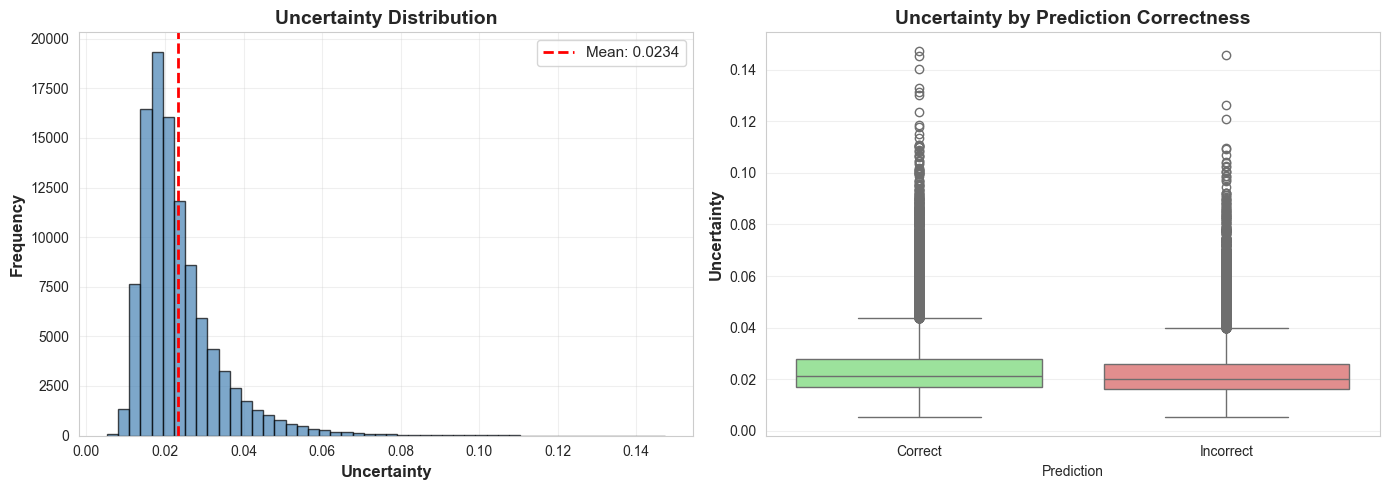

✅ Uncertainty distribution saved


In [ ]:
# Uncertainty distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(uncertainty_val, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(uncertainty_val), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(uncertainty_val):.4f}')
axes[0].set_xlabel('Uncertainty', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Uncertainty Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Box plot by correctness
correct = (y_val == y_val_pred_ens)
data_box = pd.DataFrame({
    'Uncertainty': uncertainty_val,
    'Prediction': ['Correct' if c else 'Incorrect' for c in correct]
})

sns.boxplot(data=data_box, x='Prediction', y='Uncertainty', ax=axes[1],
            palette={'Correct': 'lightgreen', 'Incorrect': 'lightcoral'})
axes[1].set_title('Uncertainty by Prediction Correctness', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Uncertainty', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/uncertainty_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Uncertainty distribution saved")

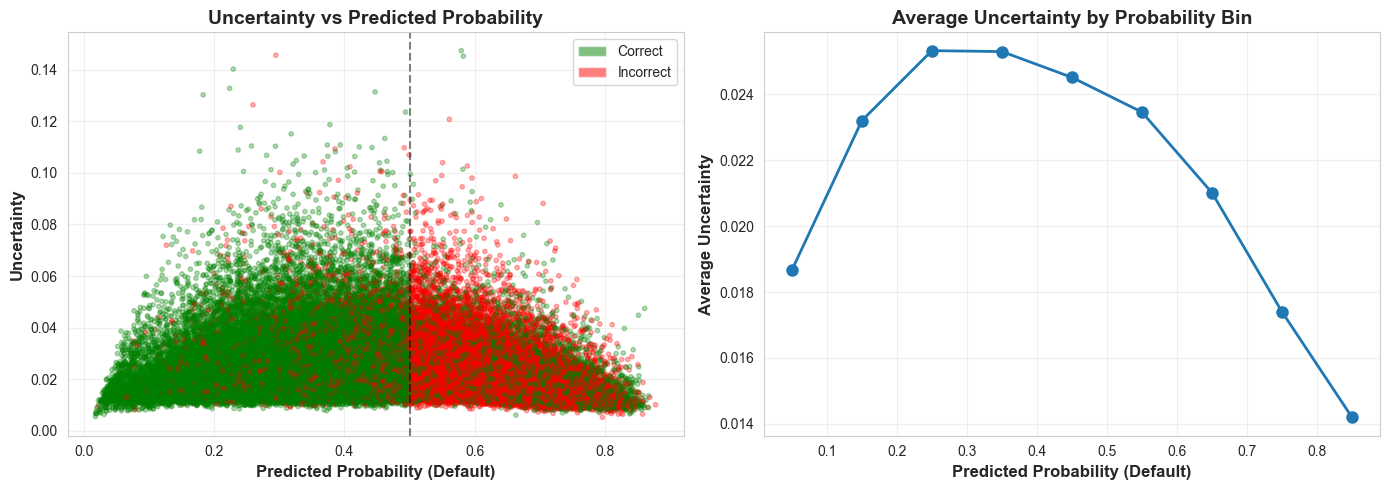

✅ Uncertainty vs probability plots saved


In [ ]:
# Uncertainty vs Probability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
colors = ['green' if c else 'red' for c in correct]
axes[0].scatter(proba_val[:, 1], uncertainty_val, c=colors, alpha=0.3, s=10)
axes[0].set_xlabel('Predicted Probability (Default)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Uncertainty', fontsize=12, fontweight='bold')
axes[0].set_title('Uncertainty vs Predicted Probability', fontsize=14, fontweight='bold')
axes[0].axvline(0.5, color='black', linestyle='--', alpha=0.5)
axes[0].grid(alpha=0.3)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.5, label='Correct'),
    Patch(facecolor='red', alpha=0.5, label='Incorrect')
]
axes[0].legend(handles=legend_elements, loc='upper right')

# Binned uncertainty by probability
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(proba_val[:, 1], bins) - 1
bin_uncertainty = [uncertainty_val[bin_indices == i].mean() 
                   for i in range(len(bins) - 1)]
bin_centers = (bins[:-1] + bins[1:]) / 2

axes[1].plot(bin_centers, bin_uncertainty, 'o-', linewidth=2, markersize=8)
axes[1].set_xlabel('Predicted Probability (Default)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Uncertainty', fontsize=12, fontweight='bold')
axes[1].set_title('Average Uncertainty by Probability Bin', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/uncertainty_vs_probability.png', dpi=300, bbox_inches='tight')
plt.show()
print("Uncertainty vs probability plots saved")

## 7. Prediction Intervals

Calculating prediction intervals...


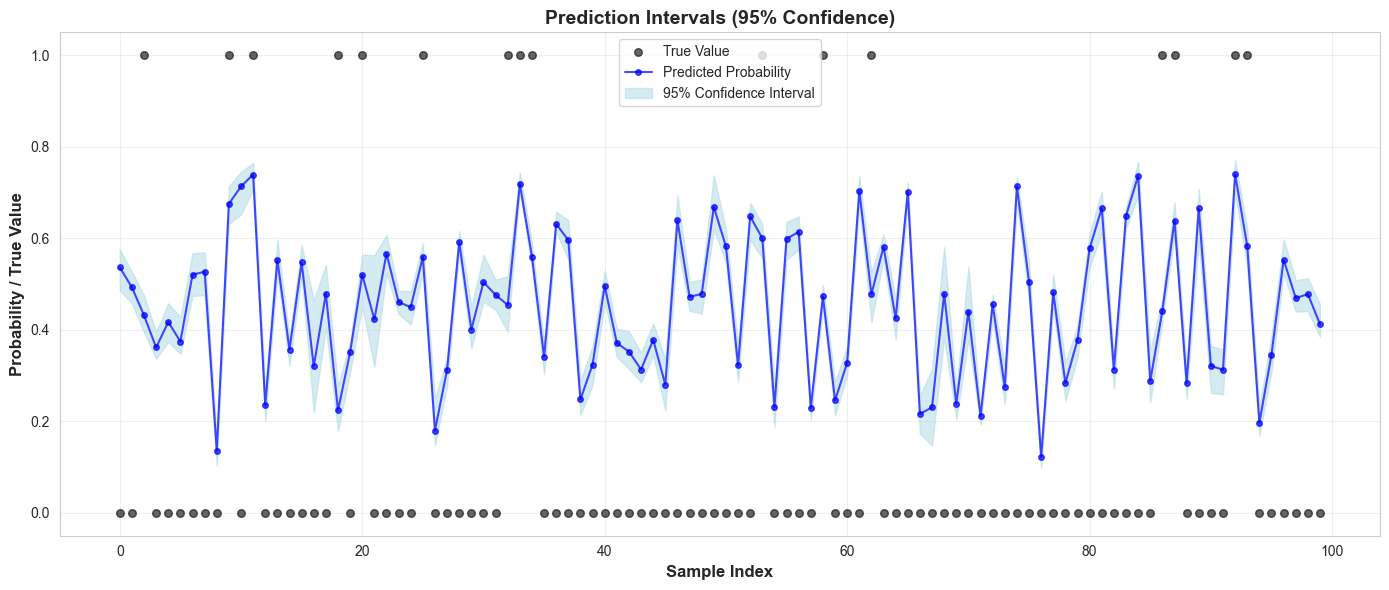

✅ Prediction intervals plot saved


In [ ]:
# Get prediction intervals
print("Calculating prediction intervals...")
proba_mean, lower_bound, upper_bound = bootstrap_ensemble.get_prediction_intervals(
    X_val, confidence=0.95
)

# Plot prediction intervals for subset
n_samples = 100
indices = np.random.choice(len(X_val), n_samples, replace=False)
indices = np.sort(indices)

plt.figure(figsize=(14, 6))
x = np.arange(n_samples)

# True values
plt.scatter(x, y_val.values[indices], color='black', s=30, 
            label='True Value', zorder=3, alpha=0.6)

# Predictions with intervals
plt.plot(x, proba_mean[indices], 'o-', color='blue', 
         label='Predicted Probability', markersize=4, alpha=0.7)
plt.fill_between(x, lower_bound[indices], upper_bound[indices], 
                 color='lightblue', alpha=0.5, label='95% Confidence Interval')

plt.xlabel('Sample Index', fontsize=12, fontweight='bold')
plt.ylabel('Probability / True Value', fontsize=12, fontweight='bold')
plt.title('Prediction Intervals (95% Confidence)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/prediction_intervals.png', dpi=300, bbox_inches='tight')
plt.show()
print("Prediction intervals plot saved")

## 8. Calibration Analysis

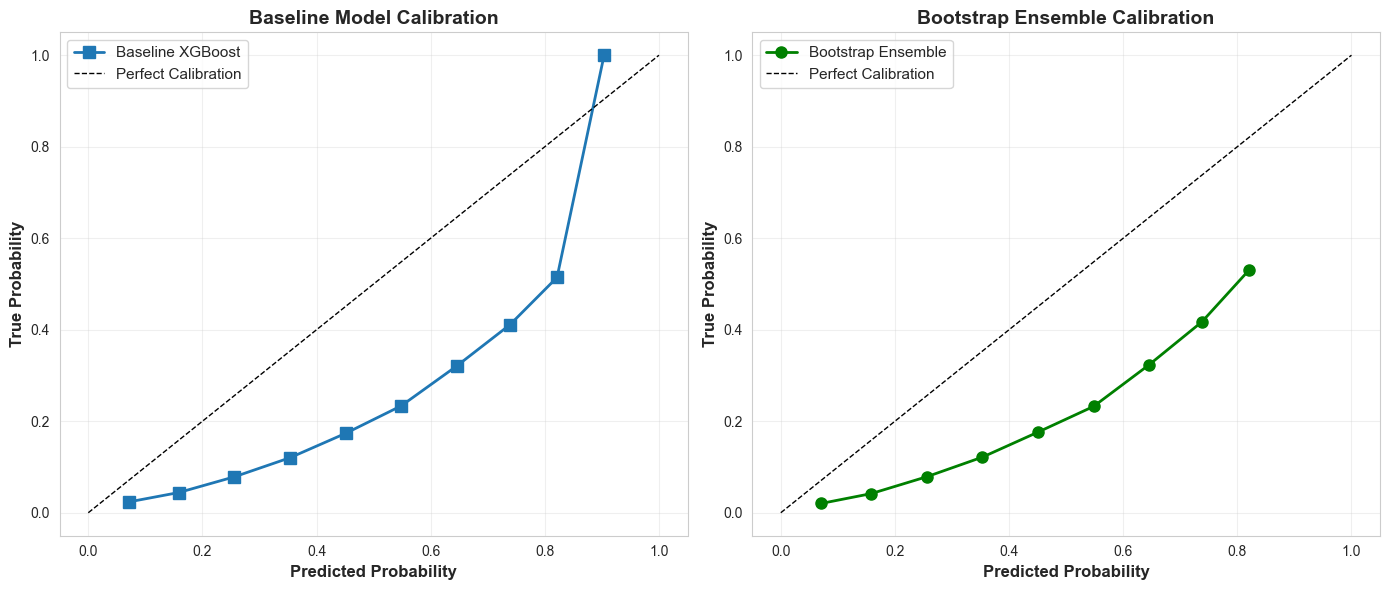

✅ Calibration comparison saved


In [ ]:
# Compare calibration: baseline vs ensemble
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline model calibration
prob_true_base, prob_pred_base = calibration_curve(
    y_val, y_val_proba, n_bins=10, strategy='uniform'
)

axes[0].plot(prob_pred_base, prob_true_base, 's-', 
             label='Baseline XGBoost', markersize=8, linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1)
axes[0].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Probability', fontsize=12, fontweight='bold')
axes[0].set_title('Baseline Model Calibration', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(alpha=0.3)

# Ensemble calibration
prob_true_ens, prob_pred_ens = calibration_curve(
    y_val, proba_val[:, 1], n_bins=10, strategy='uniform'
)

axes[1].plot(prob_pred_ens, prob_true_ens, 'o-', 
             label='Bootstrap Ensemble', markersize=8, linewidth=2, color='green')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1)
axes[1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Probability', fontsize=12, fontweight='bold')
axes[1].set_title('Bootstrap Ensemble Calibration', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/calibration_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Calibration comparison saved")

## 9. Uncertainty by Risk Level


Uncertainty by Risk Level:
            Avg Uncertainty  Std Uncertainty  Count  Default Rate
Risk Level                                                       
Very Low             0.0223           0.0102   5678        0.0375
Low                  0.0253           0.0115  29810        0.1061
Medium               0.0240           0.0100  46715        0.2034
High                 0.0200           0.0080  22045        0.3500
Very High            0.0142           0.0054    610        0.5311


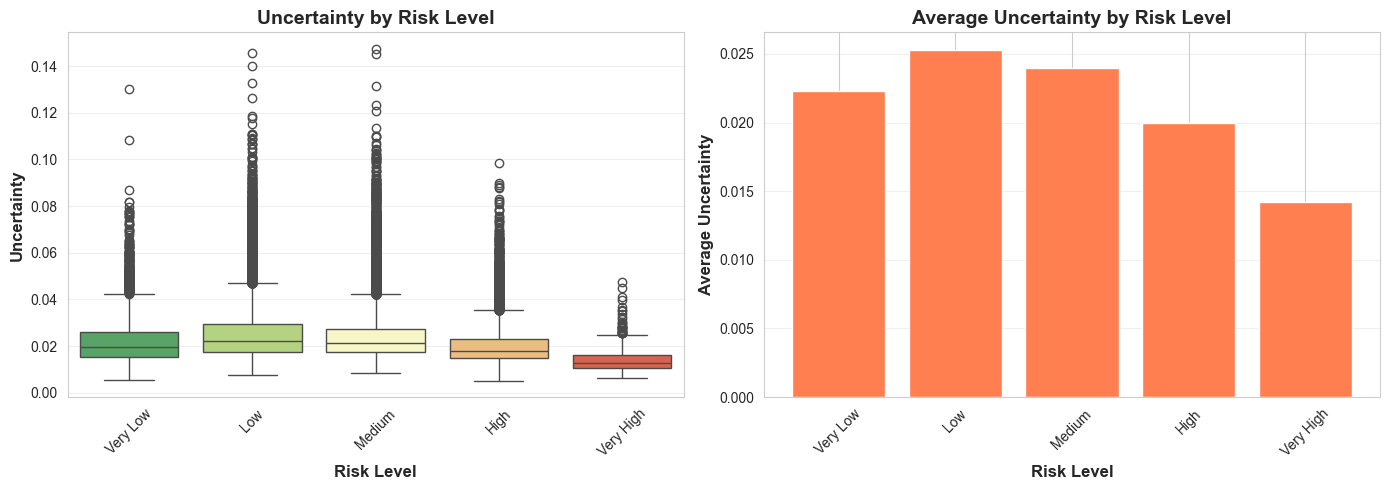

✅ Uncertainty by risk level analysis saved


In [ ]:
# Categorize by predicted risk level
risk_categories = pd.cut(
    proba_val[:, 1],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

# Analyze uncertainty by risk level
uncertainty_by_risk = pd.DataFrame({
    'Risk Level': risk_categories,
    'Uncertainty': uncertainty_val,
    'True Default': y_val.values
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
sns.boxplot(data=uncertainty_by_risk, x='Risk Level', y='Uncertainty', ax=axes[0],
            palette='RdYlGn_r')
axes[0].set_title('Uncertainty by Risk Level', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Uncertainty', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Summary statistics
summary = uncertainty_by_risk.groupby('Risk Level').agg({
    'Uncertainty': ['mean', 'std', 'count'],
    'True Default': 'mean'
}).round(4)
summary.columns = ['Avg Uncertainty', 'Std Uncertainty', 'Count', 'Default Rate']
print("\nUncertainty by Risk Level:")
print(summary)

# Heatmap
pivot_data = uncertainty_by_risk.groupby('Risk Level')['Uncertainty'].mean()
axes[1].bar(range(len(pivot_data)), pivot_data.values, color='coral')
axes[1].set_xticks(range(len(pivot_data)))
axes[1].set_xticklabels(pivot_data.index, rotation=45)
axes[1].set_ylabel('Average Uncertainty', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Risk Level', fontsize=12, fontweight='bold')
axes[1].set_title('Average Uncertainty by Risk Level', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/uncertainty_by_risk.png', dpi=300, bbox_inches='tight')
plt.show()
print("Uncertainty by risk level analysis saved")

## 10. Save Bootstrap Ensemble

In [ ]:
# Save bootstrap ensemble
print("Saving bootstrap ensemble...")
joblib.dump(bootstrap_ensemble, '../results/models/bootstrap_ensemble.pkl')
print("Bootstrap ensemble saved")

# Save uncertainty estimates for later use
uncertainty_data = {
    'val': {
        'proba': proba_val,
        'uncertainty': uncertainty_val,
        'y_true': y_val.values,
        'y_pred': y_val_pred_ens
    },
    'test': {
        'proba': proba_test,
        'uncertainty': uncertainty_test,
        'y_true': y_test.values,
        'y_pred': y_test_pred_ens
    }
}

joblib.dump(uncertainty_data, '../results/models/uncertainty_estimates.pkl')
print("Uncertainty estimates saved")

Saving bootstrap ensemble...
✅ Bootstrap ensemble saved
✅ Uncertainty estimates saved


## 11. Summary and Key Findings

In [ ]:
print("="*60)
print("PHASE 3 COMPLETE: UNCERTAINTY QUANTIFICATION")
print("="*60)

print("\nAchievements:")
print("   - Bootstrap Ensemble with 30 models trained")
print("   - Uncertainty estimates generated for all predictions")
print("   - Uncertainty quality validated (correlation with errors)")
print("   - Calibration analyzed and compared")
print("   - Prediction intervals calculated")

print("\nKey Metrics (Validation Set):")
print(f"   Ensemble Accuracy: {accuracy_score(y_val, y_val_pred_ens):.4f}")
print(f"   Ensemble AUC-ROC:  {roc_auc_score(y_val, proba_val[:, 1]):.4f}")
print(f"   Mean Uncertainty:  {np.mean(uncertainty_val):.4f}")

# Calculate correlation
errors = (y_val != y_val_pred_ens).astype(int)
correlation = np.corrcoef(uncertainty_val, errors)[0, 1]
print(f"   Uncertainty-Error Correlation: {correlation:.4f}")

# Calculate metrics
metrics = UncertaintyMetrics()
corr_results = metrics.uncertainty_vs_error_correlation(
    y_val.values, y_val_pred_ens, uncertainty_val
)
print(f"   Uncertainty Ratio (Incorrect/Correct): {corr_results['uncertainty_ratio']:.4f}")

print("\nPhase 3 Success Criteria:")
if correlation > 0.3:
    print(f"   Strong correlation (>0.3): {correlation:.4f}")
elif correlation > 0.15:
    print(f"   Moderate correlation (>0.15): {correlation:.4f}")
else:
    print(f"   Weak correlation: {correlation:.4f}")

if corr_results['uncertainty_ratio'] > 1.5:
    print(f"   Uncertainty ratio >1.5: {corr_results['uncertainty_ratio']:.4f}")
else:
    print(f"   Uncertainty ratio: {corr_results['uncertainty_ratio']:.4f}")

print("\nNext: Phase 4 - Human Escalation System")
print("   - Define escalation criteria based on uncertainty")
print("   - Optimize thresholds for cost-benefit")
print("   - Implement EscalationSystem class")
print("="*60)


PHASE 3 COMPLETE: UNCERTAINTY QUANTIFICATION

✅ Achievements:
   - Bootstrap Ensemble with 30 models trained
   - Uncertainty estimates generated for all predictions
   - Uncertainty quality validated (correlation with errors)
   - Calibration analyzed and compared
   - Prediction intervals calculated

📊 Key Metrics (Validation Set):
   Ensemble Accuracy: 0.6225
   Ensemble AUC-ROC:  0.6796
   Mean Uncertainty:  0.0234
   Uncertainty-Error Correlation: -0.0655
   Uncertainty Ratio (Incorrect/Correct): 0.9418

🎯 Phase 3 Success Criteria:
   ⚠️  Weak correlation: -0.0655
   ⚠️  Uncertainty ratio: 0.9418

🚀 Next: Phase 4 - Human Escalation System
   - Define escalation criteria based on uncertainty
   - Optimize thresholds for cost-benefit
   - Implement EscalationSystem class
